# Digital Musicology (DH-401)
## Assignment 2: Pitch and keys
Group 6
- Mickaël Achkar
- Yichen Wang
- Yinghui Jiang

In [1]:
import ms3
import pandas as pd
import numpy as np
import math
import fractions
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
import seaborn

## 0. Dataset preparation

In [2]:
%%time

# Suppress SettingWithCopy warnings
pd.options.mode.chained_assignment = None

keys_dataset = pd.read_csv('DM2022 - Assignment 2 [Dataset].csv', converters = {'duration': fractions.Fraction, 'nominal_duration': fractions.Fraction, 'scalar': fractions.Fraction}, index_col = 0, low_memory = False)
# Convert strings to bool
string_to_bool = {'True': True, 'False': False}
keys_dataset['globalkey_is_minor'].map(string_to_bool)
keys_dataset['localkey_is_minor'].map(string_to_bool)

# Get only labeled dataset
labeled_df = keys_dataset[keys_dataset['globalkey_is_minor'].notna()]

# Function to convert from cpc fifths ordering to semitones ordering
fifths_to_semitones = lambda x: x+6 if(x%2==1 and x<6) else(x-6 if(x%2==1 and x>6) else x)

# Convert to chromatic pitch-class (fifths and semitones ordering)
labeled_df['cpc_f'] = labeled_df['tpc'].mod(12)
labeled_df['cpc_s'] = labeled_df['midi'].mod(12)

labeled_df['globalkey_cpc_f'] = labeled_df.loc[:,'globalkey_tpc'].mod(12)
labeled_df['globalkey_cpc_s'] = labeled_df.loc[:,'globalkey_cpc_f'].apply(fifths_to_semitones)

labeled_df['localkey_tpc'] = labeled_df['localkey_relativetpc'] + labeled_df['globalkey_tpc']
labeled_df['localkey_cpc_f'] = labeled_df['localkey_tpc'].mod(12)
labeled_df['localkey_cpc_s'] = labeled_df['localkey_cpc_f'].apply(fifths_to_semitones)

# Transpose all pieces to C tonic (with Ground Truth)
labeled_df['cpc_f_trsp_C'] = (labeled_df['cpc_f'] - labeled_df['globalkey_cpc_f']).mod(12)
labeled_df['cpc_s_trsp_C'] = (labeled_df['cpc_s'] - labeled_df['globalkey_cpc_s']).mod(12)

# Compute all twelve transpositions for each piece
for i_f_transpose in range(12):
  labeled_df['cpc_f_trsp_'+str(i_f_transpose)] = (labeled_df['cpc_f'] - i_f_transpose).mod(12)
  i_s_transpose = fifths_to_semitones(i_f_transpose)
  labeled_df['cpc_s_trsp_'+str(i_s_transpose)] = (labeled_df['cpc_s'] - i_s_transpose).mod(12)

labeled_df

CPU times: user 5.56 s, sys: 362 ms, total: 5.92 s
Wall time: 5.95 s


,n,piece,mn,mn_onset,timesig,act_dur,staff,voice,duration,gracenote,...,cpc_f_trsp_7,cpc_s_trsp_1,cpc_f_trsp_8,cpc_s_trsp_8,cpc_f_trsp_9,cpc_s_trsp_3,cpc_f_trsp_10,cpc_s_trsp_10,cpc_f_trsp_11,cpc_s_trsp_5
0,0,MozartSonatas/K280-1,1,0,3/4,3/4,2,1,1/4,NaN,...,4,4,3,9,2,2,1,7,0,0
1,1,MozartSonatas/K280-1,1,0,3/4,3/4,2,1,1/4,NaN,...,4,4,3,9,2,2,1,7,0,0
2,2,MozartSonatas/K280-1,1,0,3/4,3/4,1,1,1/4,NaN,...,5,11,4,4,3,9,2,2,1,7
3,3,MozartSonatas/K280-1,1,0,3/4,3/4,1,1,1/4,NaN,...,4,4,3,9,2,2,1,7,0,0
4,4,MozartSonatas/K280-1,1,0,3/4,3/4,1,1,1/4,NaN,...,8,8,7,1,6,6,5,11,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404338,643,CorelliTrioSonatas/op04n04d,31,3/4,12/8,11/8,2,1,3/8,NaN,...,7,1,6,6,5,11,4,4,3,9
404339,644,CorelliTrioSonatas/op04n04d,31,3/4,12/8,11/8,1,1,3/8,NaN,...,11,5,10,10,9,3,8,8,7,1
404340,645,CorelliTrioSonatas/op04n04d,31,9/8,12/8,11/8,3,1,1/4,NaN,...,7,1,6,6,5,11,4,4,3,9
404341,646,CorelliTrioSonatas/op04n04d,31,9/8,12/8,11/8,2,1,1/4,NaN,...,7,1,6,6,5,11,4,4,3,9


In [3]:
major_df = labeled_df[labeled_df['globalkey_is_minor'] == False]
major_df[['globalkey','globalkey_tpc','globalkey_cpc_f','globalkey_cpc_s','tpc','cpc_f','cpc_s','cpc_f_trsp_C','cpc_s_trsp_C']]

,globalkey,globalkey_tpc,globalkey_cpc_f,globalkey_cpc_s,tpc,cpc_f,cpc_s,cpc_f_trsp_C,cpc_s_trsp_C
0,F,-1.0,11.0,5.0,-1,11,5,0.0,0.0
1,F,-1.0,11.0,5.0,-1,11,5,0.0,0.0
2,F,-1.0,11.0,5.0,0,0,0,1.0,7.0
3,F,-1.0,11.0,5.0,-1,11,5,0.0,0.0
4,F,-1.0,11.0,5.0,3,3,9,4.0,4.0
...,...,...,...,...,...,...,...,...,...
404338,D,2.0,2.0,2.0,2,2,2,0.0,0.0
404339,D,2.0,2.0,2.0,6,6,6,4.0,4.0
404340,D,2.0,2.0,2.0,2,2,2,0.0,0.0
404341,D,2.0,2.0,2.0,2,2,2,0.0,0.0


In [4]:
minor_df = labeled_df[labeled_df['globalkey_is_minor'] == True]
minor_df[['globalkey','globalkey_tpc','globalkey_cpc_f','globalkey_cpc_s','tpc','cpc_f','cpc_f_trsp_C','cpc_s_trsp_C']]

,globalkey,globalkey_tpc,globalkey_cpc_f,globalkey_cpc_s,tpc,cpc_f,cpc_f_trsp_C,cpc_s_trsp_C
6256,a,3.0,3.0,9.0,9,9,6.0,6.0
6257,a,3.0,3.0,9.0,3,3,0.0,0.0
6258,a,3.0,3.0,9.0,0,0,9.0,3.0
6259,a,3.0,3.0,9.0,4,4,1.0,7.0
6260,a,3.0,3.0,9.0,4,4,1.0,7.0
...,...,...,...,...,...,...,...,...
403690,e,4.0,4.0,4.0,9,9,5.0,11.0
403691,e,4.0,4.0,4.0,4,4,0.0,0.0
403692,e,4.0,4.0,4.0,4,4,0.0,0.0
403693,e,4.0,4.0,4.0,4,4,0.0,0.0


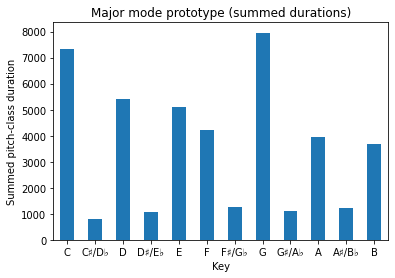

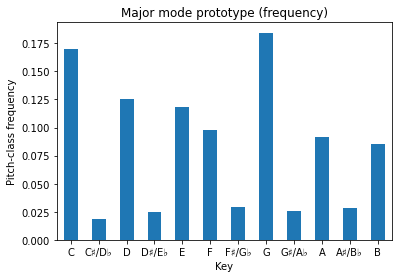

In [5]:
grouped_major_df = major_df.groupby('cpc_s_trsp_C').duration.sum().apply(float)

L1_norm = grouped_major_df.sum()
major_vec = grouped_major_df.div(L1_norm).to_numpy()

keys = ['C','C♯/D♭','D','D♯/E♭','E','F','F♯/G♭','G','G♯/A♭','A','A♯/B♭','B']
grouped_major_df.plot(kind = 'bar')
plt.xticks(range(len(keys)), keys, rotation='horizontal')
plt.xlabel('Key')
plt.ylabel('Summed pitch-class duration')
plt.title('Major mode prototype (summed durations)')
plt.show()

grouped_major_df.div(L1_norm).plot(kind = 'bar')
plt.xticks(range(len(keys)), keys, rotation='horizontal')
plt.xlabel('Key')
plt.ylabel('Pitch-class frequency')
plt.title('Major mode prototype (frequency)')
plt.show()

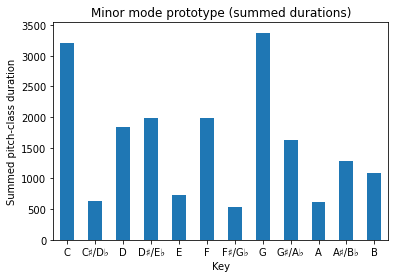

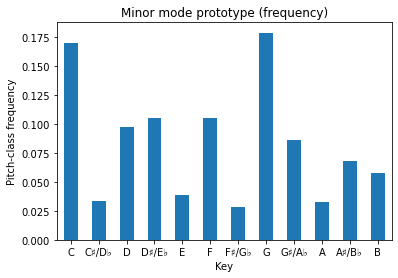

In [6]:
grouped_minor_df = minor_df.groupby('cpc_s_trsp_C').duration.sum().apply(float)

L1_norm = grouped_minor_df.sum()
minor_vec = grouped_minor_df.div(L1_norm).to_numpy()

keys = ['C','C♯/D♭','D','D♯/E♭','E','F','F♯/G♭','G','G♯/A♭','A','A♯/B♭','B']
grouped_minor_df.plot(kind = 'bar')
plt.xticks(range(len(keys)), keys, rotation='horizontal')
plt.xlabel('Key')
plt.ylabel('Summed pitch-class duration')
plt.title('Minor mode prototype (summed durations)')
plt.show()

grouped_minor_df.div(L1_norm).plot(kind = 'bar')
plt.xticks(range(len(keys)), keys, rotation='horizontal')
plt.xlabel('Key')
plt.ylabel('Pitch-class frequency')
plt.title('Minor mode prototype (frequency)')
plt.show()

In [102]:
def globalkey_classifier(piece, major_vec, minor_vec):
    piece_df = labeled_df[(labeled_df['piece'] == piece)]
    dists = np.empty([12,2])
    
    for i_s_transpose in range(12):
      grouped_df = piece_df.groupby('cpc_s_trsp_'+str(i_s_transpose)).duration.sum().apply(float)
      grouped_df = grouped_df.reindex(range(12), fill_value=0) #need to reindex as some pitch-classes never occur in some pieces
      L1_norm = grouped_df.sum()
      piece_vec = grouped_df.div(L1_norm).to_numpy()
      dists[i_s_transpose, 0] = np.linalg.norm(major_vec - piece_vec, 2)
      dists[i_s_transpose, 1] = np.linalg.norm(minor_vec - piece_vec, 2)

    tonic_mode_idx = np.unravel_index(dists.argmin(), dists.shape)
    
    tonics = ['C','C♯/D♭','D','D♯/E♭','E','F','F♯/G♭','G','G♯/A♭','A','A♯/B♭','B']
    modes = ['Major', 'minor']
    
    pred_tonic_mode = (tonics[tonic_mode_idx[0]], modes[tonic_mode_idx[1]])
    
    return pred_tonic_mode

def globalkey_groundtruth(piece):
    piece_df = labeled_df[(labeled_df['piece'] == piece)]
    
    tonics = ['C','C♯/D♭','D','D♯/E♭','E','F','F♯/G♭','G','G♯/A♭','A','A♯/B♭','B']

    tonic = tonics[int(piece_df.globalkey_cpc_s.unique()[0])]
    mode = "minor" if piece_df.globalkey_is_minor.unique()[0] else "Major"
    
    ground_truth_tonic_mode = (tonic, mode)
    
    return ground_truth_tonic_mode
    
random_piece = labeled_df['piece'].sample(n=1).item()
#piece with missing pitchclass: random_piece_df = labeled_df[(labeled_df['piece'] == 'CorelliTrioSonatas/op04n01a_reviewed')]
#Dataset: ['C','c'];['Db','c#'];['D','d'];['Eb',x];['E','e'];['F','f'];[x,x];['G','g'];['Ab','g#'];['A','a'];['Bb',x];[x,'b']

pred_tonic_mode = globalkey_classifier(random_piece, major_vec, minor_vec)
ground_truth_tonic_mode = globalkey_groundtruth(random_piece)
    
print(f'Prediction: {pred_tonic_mode[0]} {pred_tonic_mode[1]}')
print(f'Ground truth: {ground_truth_tonic_mode[0]} {ground_truth_tonic_mode[1]}')

Prediction: A♯/B♭ Major
Ground truth: A♯/B♭ Major


In [8]:
%%time

X = [] # features: piece name
y = [] # labels: tonic/mode pair
for piece in labeled_df.piece.unique():
    X.append(piece)
    y.append(globalkey_groundtruth(piece))

CPU times: user 4.45 s, sys: 54.3 ms, total: 4.51 s
Wall time: 4.75 s


In [71]:
%%time

accuracies=[]
for fold in range(100):
    # Split training and testing data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=None)

    grouped_major_df_train = major_df[major_df.piece.isin(X_train)].groupby('cpc_s_trsp_C').duration.sum().apply(float)
    grouped_minor_df_train = minor_df[minor_df.piece.isin(X_train)].groupby('cpc_s_trsp_C').duration.sum().apply(float)
    L1_norm_major = grouped_major_df_train.sum()
    L1_norm_minor = grouped_minor_df_train.sum()
    major_vec = grouped_major_df_train.div(L1_norm_major).to_numpy()
    minor_vec = grouped_minor_df_train.div(L1_norm_minor).to_numpy()

    y_test_key = []
    y_pred_key = []
    i = 0
    for piece in X_test:
        pred = globalkey_classifier(piece, major_vec, minor_vec)
        y_test_key.append(y_test[i][0]+y_test[i][1])
        y_pred_key.append(pred[0]+pred[1])
        i = i+1
    accuracies.append(metrics.accuracy_score(y_test_key, y_pred_key))

CPU times: user 9min 23s, sys: 9.26 s, total: 9min 32s
Wall time: 9min 51s


Accuracy Mean: 0.9324137931034483

Accuracy Variance: 0.0008720570749108206



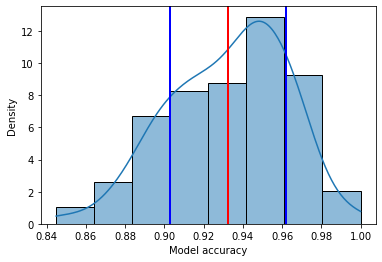

In [78]:
print("Accuracy Mean: {}\n".format(np.mean(accuracies)))
print("Accuracy Variance: {}\n".format(np.var(accuracies)))

seaborn.histplot(accuracies, kde=True, stat='density', bins=8)
plt.axvline(np.mean(accuracies), c='r', ls='-', lw=2)
plt.axvline(np.mean(accuracies)-np.std(accuracies), c='b', ls='-', lw=2)
plt.axvline(np.mean(accuracies)+np.std(accuracies), c='b', ls='-', lw=2)
plt.xlabel('Model accuracy')
plt.show()
#seaborn.violinplot(accuracies)